In [111]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')
print(df.shape)
df.head(5)

(1112, 13)


,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr
0,1,50002,1,50002,PITT,no_filename,1,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452
1,2,50003,2,50003,PITT,Pitt_0050003,1,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155
2,3,50004,3,50004,PITT,Pitt_0050004,1,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463
3,4,50005,4,50005,PITT,Pitt_0050005,1,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200
4,5,50006,5,50006,PITT,Pitt_0050006,1,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574


In [112]:
X = np.load("features.npz")['a']
y = np.load("labels.npz")['a']
y = np.select([y == 1, y == 2], [0, 1], y)

train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
print("\nTraining data samples:")
print(train_x.shape)


Training data samples:
(653, 2016)


In [113]:
from sklearn import preprocessing
import torch

#MinMaxscaler is used to scale all the features of Train & Test dataframes
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(train_x)
#x_test =  scaler.fit_transform(test_x.values)
x_test =  scaler.fit_transform(test_x)

print("Scaled values of Train set \n")
print(x_train)
print("\nScaled values of Test set \n")
print(x_test)

#Train and Test sets are converted into Tensors
x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(train_y.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)

Scaled values of Train set 

[[0.62458682 0.25869528 0.77813539 ... 0.69973366 0.64220319 0.62623055]
 [0.36619258 0.15922842 0.55327651 ... 0.69319589 0.59513916 0.49256394]
 [0.44473889 0.55010733 0.29953039 ... 0.49220317 0.62189607 0.44785573]
 ...
 [0.69060952 0.77490686 0.76992131 ... 0.68014218 0.53279481 0.55429992]
 [0.63730504 0.43471942 0.68012454 ... 0.62819085 0.72711074 0.72213087]
 [0.9276913  0.7532871  0.6978907  ... 0.86303712 0.80951451 0.80104934]]

Scaled values of Test set 

[[0.17371594 0.67910485 0.50993032 ... 0.71507732 0.69312968 0.82817554]
 [0.30584733 0.         0.48060218 ... 0.83418068 0.41021101 0.69783373]
 [0.57094588 0.63241503 0.93818587 ... 0.84096935 0.62120692 0.73941233]
 ...
 [0.3940889  0.69572294 0.48047557 ... 0.7169222  0.73136255 0.72531619]
 [0.20635841 0.22775244 0.58127283 ... 0.8653163  0.48998645 0.32111185]
 [0.48215526 0.68322656 0.52951599 ... 0.8790218  0.65768344 0.61489296]]

Train set Tensors 

tensor([[0.6246, 0.2587, 0.7781, 

In [114]:
from torch.utils.data import TensorDataset, DataLoader

#Define batch size 
bs = 64
#x_train and y_train are combined to a single TensorDataset (easier to iterate over and slice)
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#DataLoader is responsible for managing batches, & makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)

#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [115]:
from torch import nn

n_input_dim = train_x.shape[1]
#Layer size
n_hidden1 = 256  # Number of hidden nodes
n_hidden2 = 50
n_output =  1  # Number of output nodes for binary classifier

class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() #outputs probability between 0 and 1
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=2016, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [116]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay= 1e-6)
epochs = 100

In [117]:
model.train()
train_loss, valid_loss = [], []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    train_loss.append(loss.item())
    # evaluation part 
    model.eval()
    for xb, yb in test_loader:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)
        valid_loss.append(loss.item())
print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))

Epoch: 99 Training Loss:  0.3951426889002323 Valid Loss:  0.7859909201094083


In [118]:
import itertools

y_pred_list = []
model.eval()
#Model doesn't need to backpropagate the gradients in test set, so use torch.no_grad()
#reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

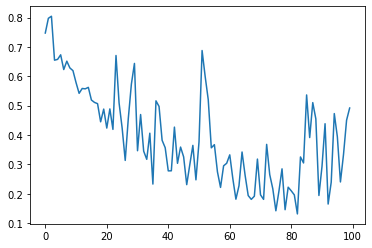

In [119]:
plt.plot(train_loss)
plt.show()

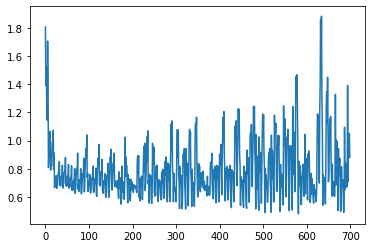

In [120]:
plt.plot(valid_loss)
plt.show()

In [121]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

#Classification accuracy
y_true_test = test_y.ravel()
print(metrics.classification_report(y_true_test,ytest_pred))

print("Precision Score : ",precision_score(y_true_test,ytest_pred, pos_label='positive', average=None))
print("Recall Score : ",recall_score(y_true_test,ytest_pred, pos_label='positive', average=None))
print("F1 Score : ",f1_score(y_true_test,ytest_pred, pos_label='positive', average=None))

              precision    recall  f1-score   support

           0       0.91      0.10      0.17       105
           1       0.54      0.99      0.70       113

    accuracy                           0.56       218
   macro avg       0.73      0.54      0.44       218
weighted avg       0.72      0.56      0.45       218

Precision Score :  [0.90909091 0.5410628 ]
Recall Score :  [0.0952381  0.99115044]
F1 Score :  [0.17241379 0.7       ]


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
